In [1]:
import pandas as pd
import mat73
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy.io as sio
from itertools import repeat
sns.set()
import matplotlib as mpl

normcolor = mpl.colors.Normalize(vmin=0.,vmax=1.)
%config InlineBackend.figure_format='retina'
mpl.rcParams['pdf.fonttype'] = 42


In [2]:
norm = pd.concat([pd.read_pickle(file) for file in glob.glob('../data/norm_signals/*.gz')], axis=1)

In [3]:
def load_hits(tf):
    motifs_hits = pd.read_csv('../data/motif_hits/motifs_hits_{}.csv'.format(tf), index_col=0)
    motifs_hits = motifs_hits.loc[:, ['Chromosome', 'start_sig', 'stop_sig', 'Strand']]
    return motifs_hits

In [4]:
def get_abs(working_norm, motifs_hits):
    signal = []
    for hit in motifs_hits.values:
        chr_loc, start, stop, strand = hit
        if strand == '+':
            signal.append(working_norm.loc[chr_loc][start:stop])
        else:
            signal.append(working_norm.loc[chr_loc][start:stop][::-1])
    return working_norm.squeeze().name, np.array(signal)

In [5]:
all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6', 'Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']

In [6]:
iterate = lambda x: get_abs(norm.loc[:, x], load_hits(x))

In [7]:
bign = norm

In [8]:
def convert_name(tf, name):
    if 'Full' in name:
        return '{}_Full'.format(tf)
    elif 'Gal4AD' in name:
        return '{}_DBDGal4AD'.format(tf)
    elif 'Gcn4AD' in name:
        return '{}_DBDGcn4AD'.format(tf)
    else:
        return tf

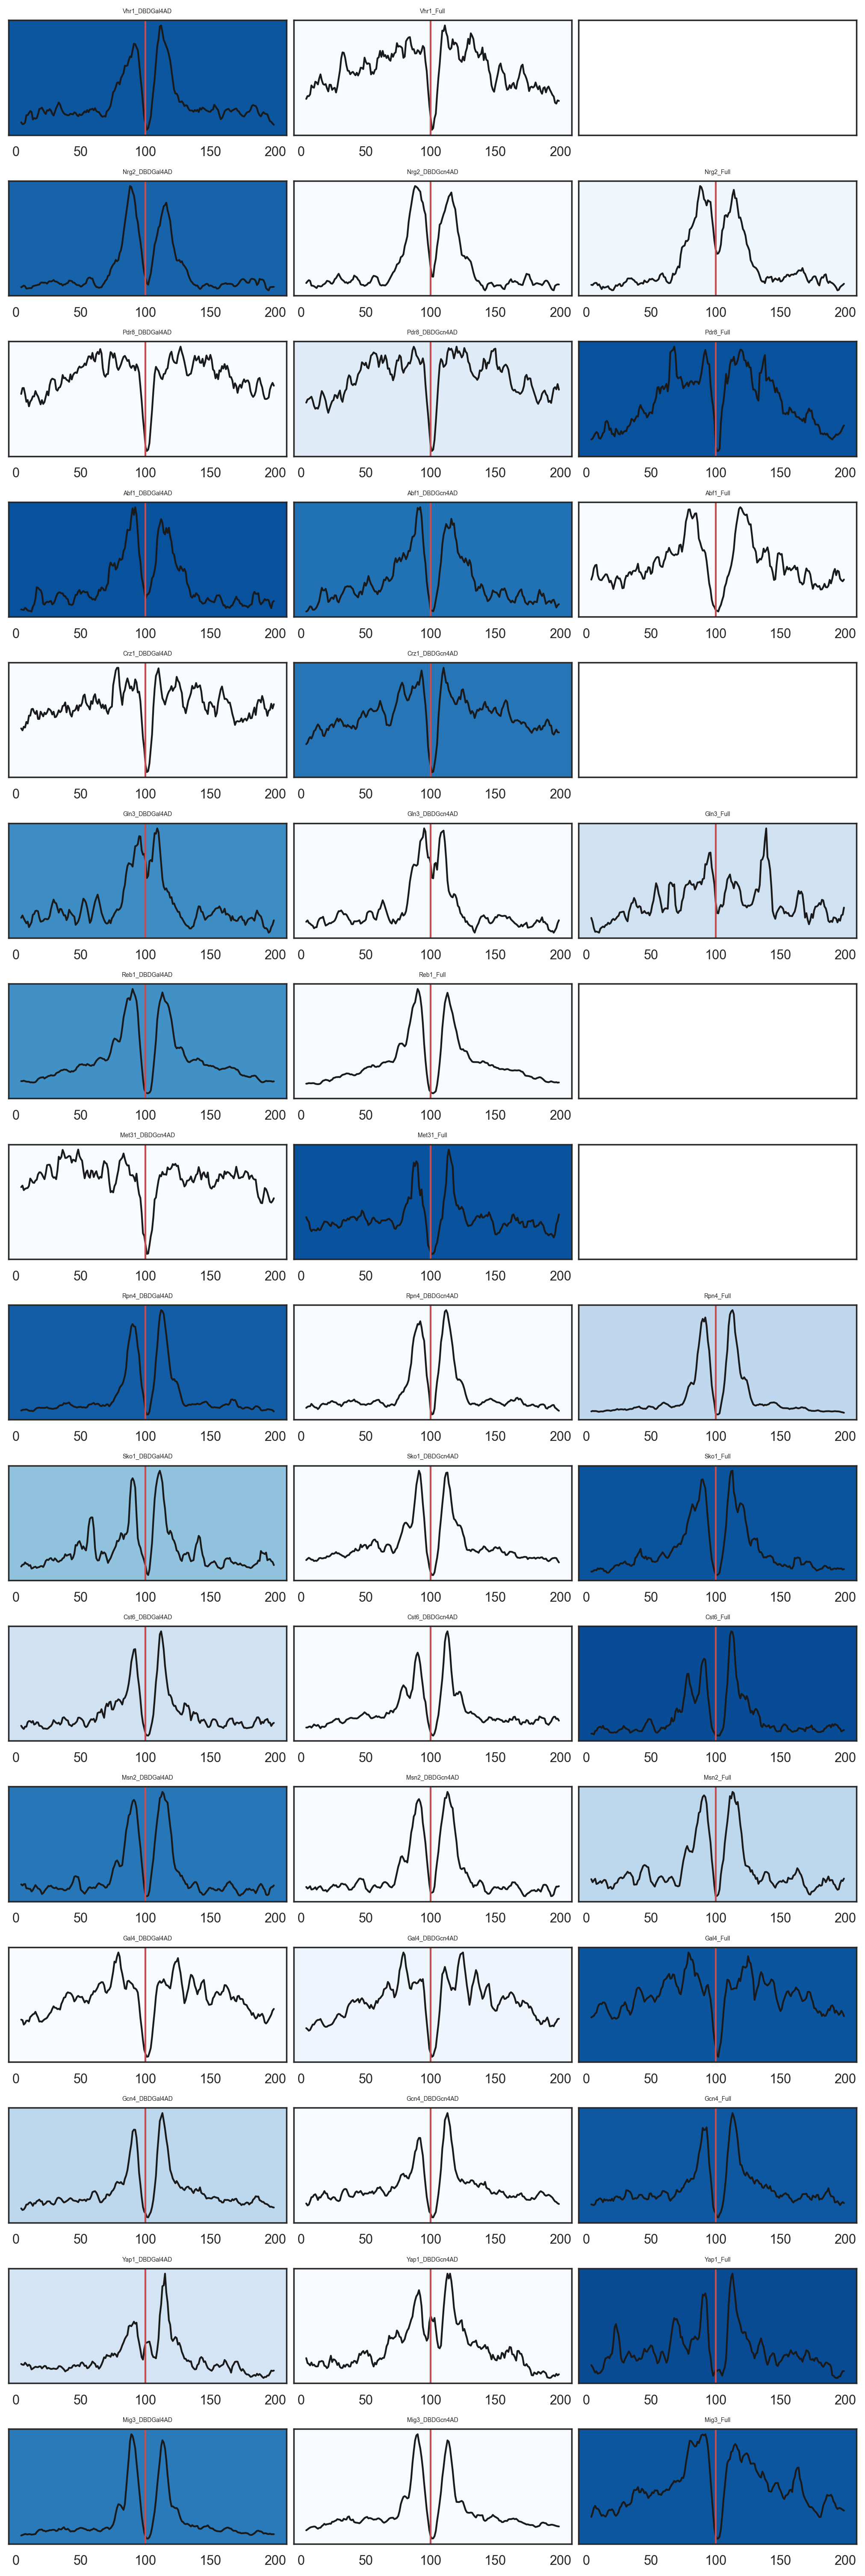

In [9]:
cmap = sns.color_palette('Blues', as_cmap=True)
fig=plt.figure(constrained_layout=True, figsize=(10,30))
subfigs = fig.subfigures(len(all_tfs),1)
for k,tf in enumerate(all_tfs):
    sns.set_style('white')
    curr_tf = bign.filter(regex='^{}'.format(tf)).filter(regex='tef').columns.values
    ax = subfigs[k].subplots(1, 3, sharey=False)


    mt_ht = load_hits(tf)
    dat_list = []
    max_list = []
    names = []
    for num,i in enumerate(curr_tf):
        name, sig = get_abs(bign.loc[:, i], mt_ht)
        smooth = pd.DataFrame(sig).rolling(window=5, axis=1).mean()

        dat_list.append(smooth.mean())
        max_list.append(smooth.mean().max())
        names.append(name)
    for num,i in enumerate(dat_list):
        normc = mpl.colors.Normalize(vmin=np.array(max_list).min(),vmax=np.array(max_list).max()+np.array(max_list).max()*0.1)


        ax[num].plot(dat_list[num], c='k')
        ax[num].set_title(convert_name(tf, names[num]), size=5)
        ax[num].set_facecolor(cmap(normc(max_list[num])))
        ax[num].set_yticklabels('')
        ax[num].axvline(100, c='r')

    if num!=2:
        ax[-1].set_yticklabels('')
        ax[-1].set_xticklabels('')

# fig.savefig('../figures_finalized/supp/meta_mots_nodelall.pdf', bbox_inches = 'tight')

In [10]:
import os
from Bio import motifs as mots
pseudocounts={'A':1-0.3829736683443062, 'C': 0.3829736683443062, 'G': 0.3829736683443062, 'T': 1-0.3829736683443062}
background={'A':(1-0.3829736683443062)/2, 'C': 0.3829736683443062/2, 'G': 0.3829736683443062/2, 'T': (1-0.3829736683443062)/2}
import logomaker

In [11]:
tfs=['Nrg2', 'Pdr8', 'Abf1', 'Crz1', 'Gln3', 'Reb1', 'Met31', 'Rpn4', 'Sko1', 'Cst6', 'Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Gln3', 'Rpn4', 'Vhr1']
codes=['M00909_2.00', 'M00098_2.00', 'M00001_2.00', 'M00038_2.00', 'M00048_2.00', 'M00063_2.00', 'M00040_2.00', 'M00017_2.00',
       'M00907_2.00', 'M00014_2.00', 'M00036_2.00', 'M01599_2.00', 'YEL009C_1363', 'M01524_2.00', 'M00023_2.00', 'M00048_2.00', 'M00017_2.00', 'M00917_2.00']
code_tf = dict(zip(codes, tfs))

with open('../data/Saccharomyces_cerevisiae_CISBP2_edited.meme') as handle:
    record = mots.parse(handle, "minimal")
    motifs_d_f_r = dict()
    for r in record:
        r.pseudocounts = pseudocounts
        r.background = background
        f_m = r.pssm
        r_m = r.reverse_complement().pssm
        if r.name in list(code_tf.keys()):
            motifs_d_f_r[code_tf[r.name]] = (f_m, r_m)

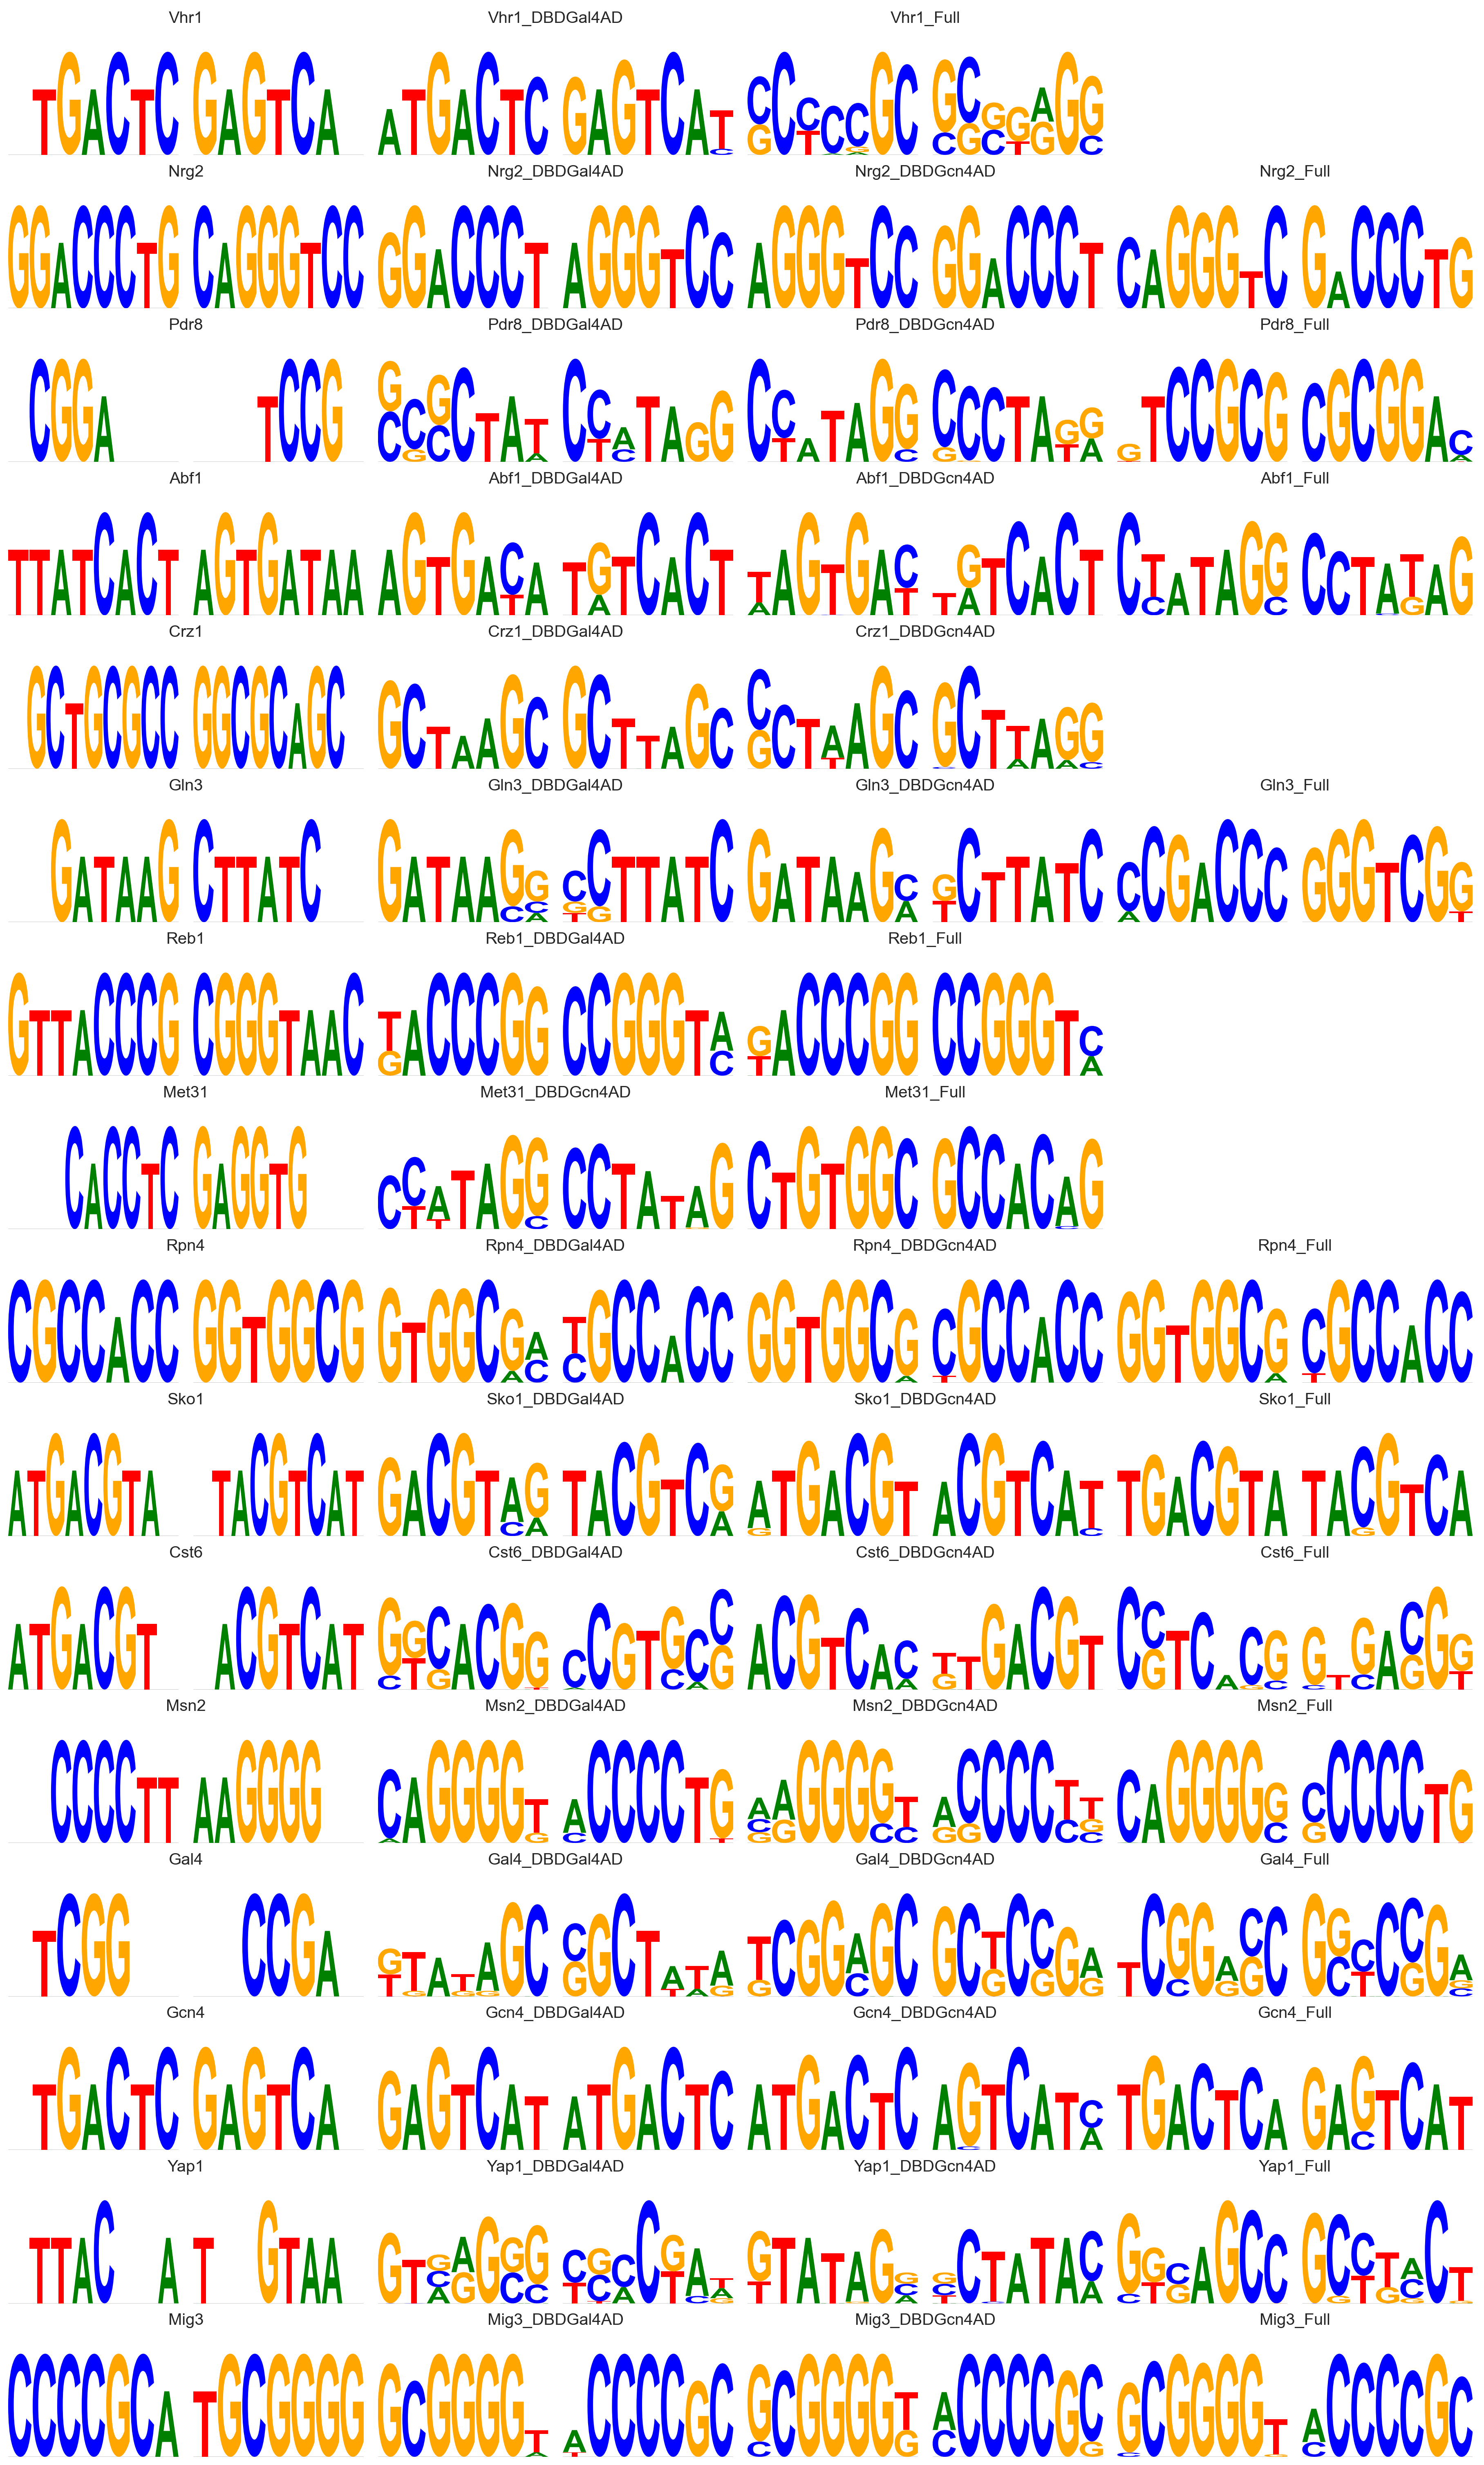

In [12]:

fig = plt.figure(figsize=(18,30), constrained_layout=True)
subfigs = fig.subfigures(len(all_tfs), 1)
lim = 1.5

for k, tf in enumerate(all_tfs):
    nested_subf=subfigs[k].subfigures(1, 4)
    to_plot_logo = bign.filter(regex='^{}'.format(tf))
    ax = nested_subf[0].subplots(1,2, sharey=True)
    f_m, r_m = motifs_d_f_r[tf]

    a = logomaker.Logo(pd.DataFrame(f_m), show_spines=False, ax=ax[0])
    b = logomaker.Logo(pd.DataFrame(r_m), show_spines=False, ax=ax[1])
    a.ax.set_ylim([0,lim])
    b.ax.set_ylim([0,lim])
    a.ax.set_xticklabels('')
    b.ax.set_xticklabels('')
    a.ax.set_yticklabels('')
    b.ax.set_yticklabels('')
    nested_subf[0].suptitle(tf)
    
    for i,strain in enumerate(to_plot_logo):
        ax = nested_subf[i+1].subplots(1,2, sharey=True)
        f,r = glob.glob(os.path.join('../data/motif_pwms/', '_'.join(strain.split('_')[:-1]).replace('.', '_')+'*'))
        with open(f, 'r') as l:
            f_m = mots.read(l, 'pfm-four-rows')
            f_m.pseudocounts = pseudocounts
            f_m.background = background

        with open(r, 'r') as l:
            r_m = mots.read(l, 'pfm-four-rows')
            r_m.pseudocounts = pseudocounts
            r_m.background = background

        a = logomaker.Logo(pd.DataFrame(f_m.pssm), show_spines=False, ax=ax[0])
        b = logomaker.Logo(pd.DataFrame(r_m.pssm), show_spines=False, ax=ax[1])
        a.ax.set_ylim([0,lim])
        b.ax.set_ylim([0,lim])
        a.ax.set_xticklabels('')
        b.ax.set_xticklabels('')
        a.ax.set_yticklabels('')
        b.ax.set_yticklabels('')
        nested_subf[i+1].suptitle(convert_name(tf,strain))
# fig.savefig('../figures_finalized/supp/seqlogos.pdf', bbox_inches = 'tight')